In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.
/home/roebius/pj/p3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
limit_mem()

In [3]:
from keras.datasets.cifar10 import load_batch

This notebook contains a Keras implementation of Huang et al.'s [DenseNet](https://arxiv.org/abs/1608.06993)

Our motivation behind studying DenseNet is because of how well it works with limited data.

DenseNet beats state-of-the-art results on CIFAR-10/CIFAR-100 w/ and w/o data augmentation, but the performance increase is most pronounced w/o data augmentation.

Compare to FractalNet, state-of-the-art on both datasets:
* CIFAR-10: ~ 30 % performance increase w/ DenseNet
* CIFAR-100: ~ 30 % performance increase w/ DenseNet

That increase is motivation enough.

So what is a DenseNet?

Put simply, DenseNet is a Resnet where we replace addition with concatenation.

## Idea

Recall that in broad terms, a Resnet is a Convnet that uses residual block structures.

These "blocks" work as follows:
* Let L<sub>t</sub> be the input layer to block
* Perform conv layer transformations/activations on L<sub>t</sub>, denote by f(<sub>t</sub>)
* Call output layer of block L<sub>t+1</sub>
* Define L<sub>t+1</sub> = f(L<sub>t</sub>)+ L<sub>t</sub>  
    * That is, total output is the conv layer outputs plus the original input
* We call residual block b.c. f(L<sub>t</sub>)=L<sub>t+1</sub> - L<sub>t</sub>, the residual
    

As mentioned, the difference w/ DenseNet is instead of adding L<sub>t</sub> to L<sub>t+1</sub>, it is being concatenated.

As with Resnet, DenseNet consists of multiple blocks.
Therefore, there is a recursive relationship across blocks:
* Block B<sub>i</sub> takes as input the ouput of block B<sub>i-1</sub> concatenated with the input of B<sub>i-1</sub>
* The input to B<sub>i-1</sub> is the ouput of block B<sub>i-2</sub> concatenated with the input of B<sub>i-2</sub>
* So on and so forth

The number of filters added to each layer needs to be monitored, given that the input space for each block keeps growing.

Huang et al. calls the # of filters added at each layer the *growth rate*, and appropriately denotes this number with the related letter *k*.

# Densenet / CIFAR 10

From http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

Let's load data.

In [4]:
def load_data():
    path = 'data/cifar-10-batches-py'
    num_train_samples = 50000
    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(path, 'data_batch_' + str(i)))
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels
    x_test, y_test = load_batch(os.path.join(path, 'test_batch'))
    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))
    x_train = x_train.transpose(0, 2, 3, 1)
    x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

In [5]:
(x_train, y_train), (x_test, y_test) = load_data()

Here's an example of CIFAR-10

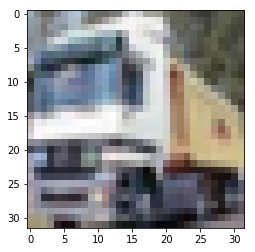

In [6]:
plt.imshow(x_train[1])

We want to normalize pixel values (0-255) to unit interval.

In [7]:
x_train = x_train/255.
x_test = x_test/255.

## Densenet

### The pieces

Let's make some helper functions for piecing together our network using Keras' Functional API.

These components should all be familiar to you:
* Relu activation
* Dropout regularization
* Batch-normalization

In [8]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization()(x)  # Keras 2 (axix=-1 is default for TensorFlow image dim ordering)
def relu_bn(x): return relu(bn(x))

Convolutional layer:
* L2 Regularization
* 'same' border mode returns same width/height
* Pass output through Dropout


In [9]:
def conv(x, nf, sz, wd, p):
    x = Conv2D(nf, (sz, sz), kernel_initializer='he_uniform', padding='same',  # Keras 2
                          kernel_regularizer=l2(wd))(x)
    return dropout(x,p)

Define ConvBlock as sequence:
* Batchnorm
* ReLU Activation
* Conv layer (conv w/ Dropout)

The authors also use something called a *bottleneck* layer to reduce dimensionality of inputs. 

Recall that the filter space dimensionality grows at each block. The input dimensionality will determine the dimensionality of your convolution weight matrices, i.e. # of parameters.

At size 3x3 or larger, convolutions can become extremely costly and # of parameters can increase quickly as a function of the input feature (filter) space. Therefore, a smart approach is to reduce dimensionality of filters by using a 1x1 convolution w/ smaller # of filters before the larger convolution.

Bottleneck consists of:
* 1x1 conv
* Compress # of filters into growth factor `nf` * 4
* Batchnorm -> ReLU

In [10]:
def conv_block(x, nf, bottleneck=False, p=None, wd=0):
    x = relu_bn(x)
    if bottleneck: x = relu_bn(conv(x, nf * 4, 1, wd, p))
    return conv(x, nf, 3, wd, p)

Now we can define the dense block:
* Take given input `x`
* Pass through a conv block for output `b`
* Concatenate input `x` and conv block output `b`
* Set concatenation as new input `x` for next block
* Repeat

In [11]:
def dense_block(x, nb_layers, growth_rate, bottleneck=False, p=None, wd=0):
    if bottleneck: nb_layers //= 2
    for i in range(nb_layers):
        b = conv_block(x, growth_rate, bottleneck=bottleneck, p=p, wd=wd)
        x = concatenate([x,b])  # Keras 2
    return x

As typical for CV architectures, we'll do some pooling after computation.

We'll define this unit as the transition block, and we'll put one between each dense block.

Aside from BN -> ReLU and Average Pooling, there is also an option for filter *compression* in this block. This is simply feature reduction via 1x1 conv as discussed before, where the new # of filters is a percentage of the incoming # of filters.

Together with bottleneck, compression has been shown to improve performance and computational efficiency of DenseNet architectures. (the authors call this DenseNet-BC)

In [12]:
def transition_block(x, compression=1.0, p=None, wd=0):
    nf = int(x.get_shape().as_list()[-1] * compression)
    x = relu_bn(x)
    x = conv(x, nf, 1, wd, p)
    return AveragePooling2D((2, 2), strides=(2, 2))(x)

### Build the DenseNet model

We've now defined all the building blocks (literally) to put together a DenseNet.

- nb_classes: number of classes
- img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
- depth: total number of layers 
    - Includes 4 extra non-block layers
        - 1 input conv, 3 output layers
- nb_block: number of dense blocks (generally = 3). 
    - NOTE: Layers / block are evenly allocated. Therefore nb_block must be a factor of (Depth - 4)
- growth_rate: number of filters to add per dense block
- nb_filter:  initial number of filters
- bottleneck: add bottleneck blocks
- Compression: Filter compression factor in transition blocks.
- p: dropout rate
- wd: weight decay
- activation: Type of activation at the top layer. Can be one of 'softmax' or 'sigmoid'. Note that if sigmoid is used, classes must be 1.

Returns: keras tensor with nb_layers of conv_block appended

From start to finish, this generates:
* Conv input layer
* Alternate between Dense/Transition blocks `nb_block` times, ommitting Transition block after last Dense block
    * Each Dense block has `(Depth-4)/nb_block` layers
* Pass final Dense block to BN -> ReLU
* Global Avg Pooling
* Dense layer w/ desired output activation

In [13]:
def create_dense_net(nb_classes, img_input, depth=40, nb_block=3, 
     growth_rate=12, nb_filter=16, bottleneck=False, compression=1.0, p=None, wd=0, activation='softmax'):
    
    assert activation == 'softmax' or activation == 'sigmoid'
    assert (depth - 4) % nb_block == 0
    nb_layers_per_block = int((depth - 4) / nb_block)
    nb_layers = [nb_layers_per_block] * nb_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    for i,block in enumerate(nb_layers):
        x = dense_block(x, block, growth_rate, bottleneck=bottleneck, p=p, wd=wd)
        if i != len(nb_layers)-1:
            x = transition_block(x, compression=compression, p=p, wd=wd)

    x = relu_bn(x)
    x = GlobalAveragePooling2D()(x)
    return Dense(nb_classes, activation=activation, kernel_regularizer=l2(wd))(x)  # Keras 2

### Train

Now we can test it out on CIFAR-10.

In [14]:
input_shape = (32,32,3)

In [15]:
img_input = Input(shape=input_shape)

In [16]:
x = create_dense_net(10, img_input, depth=100, nb_filter=16, compression=0.5, 
                     bottleneck=True, p=0.2, wd=1e-4)

In [17]:
model = Model(img_input, x)

In [18]:
model.compile(loss='sparse_categorical_crossentropy', 
      optimizer=keras.optimizers.SGD(0.1, 0.9, nesterov=True), metrics=["accuracy"])

In [19]:
parms = {'verbose': 2, 'callbacks': [TQDMNotebookCallback()]}

In [20]:
K.set_value(model.optimizer.lr, 0.1)

This will likely need to run overnight + lr annealing...

In [21]:
model.fit(x_train, y_train, 64, 20, validation_data=(x_test, y_test), **parms)

Train on 50000 samples, validate on 10000 samples


A Jupyter Widget

A Jupyter Widget

Epoch 1/20
49984/|/[loss: 1.960, acc: 0.493] 100%|| 49984/50000 [08:20<00:00, 105.03it/s]509s - loss: 1.9601 - acc: 0.4930 - val_loss: 2.7389 - val_acc: 0.3095


A Jupyter Widget

Epoch 2/20
49984/|/[loss: 1.426, acc: 0.661] 100%|| 49984/50000 [08:11<00:00, 103.65it/s]506s - loss: 1.4255 - acc: 0.6606 - val_loss: 1.5477 - val_acc: 0.6289


A Jupyter Widget

Epoch 3/20
49984/|/[loss: 1.189, acc: 0.726] 100%|| 49984/50000 [08:15<00:00, 103.77it/s]506s - loss: 1.1890 - acc: 0.7258 - val_loss: 2.6631 - val_acc: 0.4676


A Jupyter Widget

Epoch 4/20
49984/|/[loss: 1.039, acc: 0.764] 100%|| 49984/50000 [08:20<00:00, 104.49it/s]505s - loss: 1.0384 - acc: 0.7644 - val_loss: 1.1955 - val_acc: 0.7383


A Jupyter Widget

Epoch 5/20
49984/|/[loss: 0.945, acc: 0.788] 100%|| 49984/50000 [08:15<00:00, 104.53it/s]504s - loss: 0.9452 - acc: 0.7883 - val_loss: 1.1518 - val_acc: 0.7218


A Jupyter Widget

Epoch 6/20
49984/|/[loss: 0.879, acc: 0.801] 100%|| 49984/50000 [08:11<00:00, 104.63it/s]504s - loss: 0.8788 - acc: 0.8011 - val_loss: 1.1629 - val_acc: 0.7149


A Jupyter Widget

Epoch 7/20
49984/|/[loss: 0.828, acc: 0.815] 100%|| 49984/50000 [08:17<00:00, 104.27it/s]503s - loss: 0.8284 - acc: 0.8148 - val_loss: 1.1896 - val_acc: 0.7249


A Jupyter Widget

Epoch 8/20
49984/|/[loss: 0.792, acc: 0.824] 100%|| 49984/50000 [08:14<00:00, 104.36it/s]503s - loss: 0.7916 - acc: 0.8238 - val_loss: 0.9038 - val_acc: 0.7912


A Jupyter Widget

Epoch 9/20


KeyboardInterrupt: 

In [22]:
K.set_value(model.optimizer.lr, 0.01)

40064/|/[loss: 0.761, acc: 0.834]  80%|| 40064/50000 [06:40<01:34, 104.62it/s]

In [23]:
model.fit(x_train, y_train, 64, 4, validation_data=(x_test, y_test), **parms)

Train on 50000 samples, validate on 10000 samples


A Jupyter Widget

A Jupyter Widget

Epoch 1/4
49984/|/[loss: 0.627, acc: 0.879] 100%|| 49984/50000 [08:13<00:00, 104.85it/s]505s - loss: 0.6273 - acc: 0.8791 - val_loss: 0.6600 - val_acc: 0.8677


A Jupyter Widget

Epoch 2/4
49984/|/[loss: 0.571, acc: 0.898] 100%|| 49984/50000 [08:18<00:00, 103.56it/s]505s - loss: 0.5710 - acc: 0.8976 - val_loss: 0.6683 - val_acc: 0.8655


A Jupyter Widget

Epoch 3/4
49984/|/[loss: 0.546, acc: 0.903] 100%|| 49984/50000 [08:13<00:00, 104.07it/s]505s - loss: 0.5463 - acc: 0.9028 - val_loss: 0.6212 - val_acc: 0.8790


A Jupyter Widget

Epoch 4/4
49984/|/[loss: 0.525, acc: 0.908] 100%|| 49984/50000 [08:17<00:00, 103.72it/s]505s - loss: 0.5252 - acc: 0.9078 - val_loss: 0.6305 - val_acc: 0.8765



In [ ]:
K.set_value(model.optimizer.lr, 0.1)

In [ ]:
model.fit(x_train, y_train, 64, 20, validation_data=(x_test, y_test), **parms)

In [ ]:
K.set_value(model.optimizer.lr, 0.01)

In [ ]:
model.fit(x_train, y_train, 64, 40, validation_data=(x_test, y_test), **parms)

In [ ]:
K.set_value(model.optimizer.lr, 0.001)

In [ ]:
model.fit(x_train, y_train, 64, 20, validation_data=(x_test, y_test), **parms)

In [ ]:
K.set_value(model.optimizer.lr, 0.01)

In [ ]:
model.fit(x_train, y_train, 64, 10, validation_data=(x_test, y_test), **parms)

In [ ]:
K.set_value(model.optimizer.lr, 0.001)

In [ ]:
model.fit(x_train, y_train, 64, 20, validation_data=(x_test, y_test), **parms)

And we're able to replicate their state-of-the-art results!

In [ ]:
%time model.save_weights('models/93.h5')

## End